# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


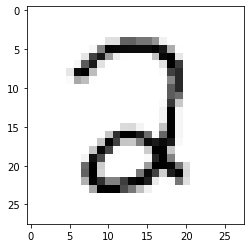

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2344
Training Accuracy: 0.6866, Testing Accuracy: 0.7082



Epoch 10, Loss 0.0866
Training Accuracy: 0.9242, Testing Accuracy: 0.9410



Epoch 20, Loss 0.0551
Training Accuracy: 0.9433, Testing Accuracy: 0.9526



Epoch 30, Loss 0.0441
Training Accuracy: 0.9513, Testing Accuracy: 0.9607



Epoch 40, Loss 0.0383
Training Accuracy: 0.9566, Testing Accuracy: 0.9662



Epoch 50, Loss 0.0347
Training Accuracy: 0.9608, Testing Accuracy: 0.9677



Epoch 60, Loss 0.0321
Training Accuracy: 0.9629, Testing Accuracy: 0.9703



Epoch 70, Loss 0.0302
Training Accuracy: 0.9651, Testing Accuracy: 0.9703



Epoch 80, Loss 0.0286
Training Accuracy: 0.9676, Testing Accuracy: 0.9708



Epoch 90, Loss 0.0273
Training Accuracy: 0.9689, Testing Accuracy: 0.9713



Epoch 100, Loss 0.0263
Training Accuracy: 0.9699, Testing Accuracy: 0.9718



Epoch 110, Loss 0.0254
Training Accuracy: 0.9706, Testing Accuracy: 0.9708



Epoch 120, Loss 0.0245
Training Accuracy: 0.9716, Testing Accuracy: 0.9708



Epoch 130, Loss 0.0238
Training Accuracy: 0.9725, Testing Accuracy: 0.9708



Epoch 140, Loss 0.0232
Training Accuracy: 0.9730, Testing Accuracy: 0.9708



Epoch 150, Loss 0.0226
Training Accuracy: 0.9741, Testing Accuracy: 0.9718



Epoch 160, Loss 0.022
Training Accuracy: 0.9749, Testing Accuracy: 0.9723



Epoch 170, Loss 0.0215
Training Accuracy: 0.9754, Testing Accuracy: 0.9728



Epoch 180, Loss 0.0211
Training Accuracy: 0.9760, Testing Accuracy: 0.9733



Epoch 190, Loss 0.0206
Training Accuracy: 0.9768, Testing Accuracy: 0.9738



Epoch 200, Loss 0.0202
Training Accuracy: 0.9770, Testing Accuracy: 0.9748



Epoch 210, Loss 0.0198
Training Accuracy: 0.9777, Testing Accuracy: 0.9748



Epoch 220, Loss 0.0195
Training Accuracy: 0.9784, Testing Accuracy: 0.9753



Epoch 230, Loss 0.0191
Training Accuracy: 0.9784, Testing Accuracy: 0.9753



Epoch 240, Loss 0.0188
Training Accuracy: 0.9791, Testing Accuracy: 0.9748



0.00842873248194279

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2246
Training Accuracy: 0.7524, Testing Accuracy: 0.7354



Epoch 10, Loss 0.102
Training Accuracy: 0.9095, Testing Accuracy: 0.9183



Epoch 20, Loss 0.0789
Training Accuracy: 0.9267, Testing Accuracy: 0.9360



Epoch 30, Loss 0.0681
Training Accuracy: 0.9348, Testing Accuracy: 0.9430



Epoch 40, Loss 0.0615
Training Accuracy: 0.9408, Testing Accuracy: 0.9486



Epoch 50, Loss 0.0571
Training Accuracy: 0.9440, Testing Accuracy: 0.9491



Epoch 60, Loss 0.0538
Training Accuracy: 0.9465, Testing Accuracy: 0.9536



Epoch 70, Loss 0.0512
Training Accuracy: 0.9489, Testing Accuracy: 0.9556



Epoch 80, Loss 0.0492
Training Accuracy: 0.9501, Testing Accuracy: 0.9587



Epoch 90, Loss 0.0475
Training Accuracy: 0.9515, Testing Accuracy: 0.9592



Epoch 100, Loss 0.046
Training Accuracy: 0.9525, Testing Accuracy: 0.9617



Epoch 110, Loss 0.0448
Training Accuracy: 0.9536, Testing Accuracy: 0.9627



Epoch 120, Loss 0.0437
Training Accuracy: 0.9542, Testing Accuracy: 0.9642



Epoch 130, Loss 0.0428
Training Accuracy: 0.9548, Testing Accuracy: 0.9652



Epoch 140, Loss 0.042
Training Accuracy: 0.9559, Testing Accuracy: 0.9657



Epoch 150, Loss 0.0412
Training Accuracy: 0.9565, Testing Accuracy: 0.9657



Epoch 160, Loss 0.0406
Training Accuracy: 0.9571, Testing Accuracy: 0.9657



Epoch 170, Loss 0.0399
Training Accuracy: 0.9578, Testing Accuracy: 0.9657



Epoch 180, Loss 0.0394
Training Accuracy: 0.9583, Testing Accuracy: 0.9657



Epoch 190, Loss 0.0389
Training Accuracy: 0.9588, Testing Accuracy: 0.9662



Epoch 200, Loss 0.0384
Training Accuracy: 0.9593, Testing Accuracy: 0.9662



Epoch 210, Loss 0.0379
Training Accuracy: 0.9596, Testing Accuracy: 0.9657



Epoch 220, Loss 0.0375
Training Accuracy: 0.9601, Testing Accuracy: 0.9662



Epoch 230, Loss 0.0371
Training Accuracy: 0.9608, Testing Accuracy: 0.9662



Epoch 240, Loss 0.0368
Training Accuracy: 0.9609, Testing Accuracy: 0.9667



0.006276097879708597

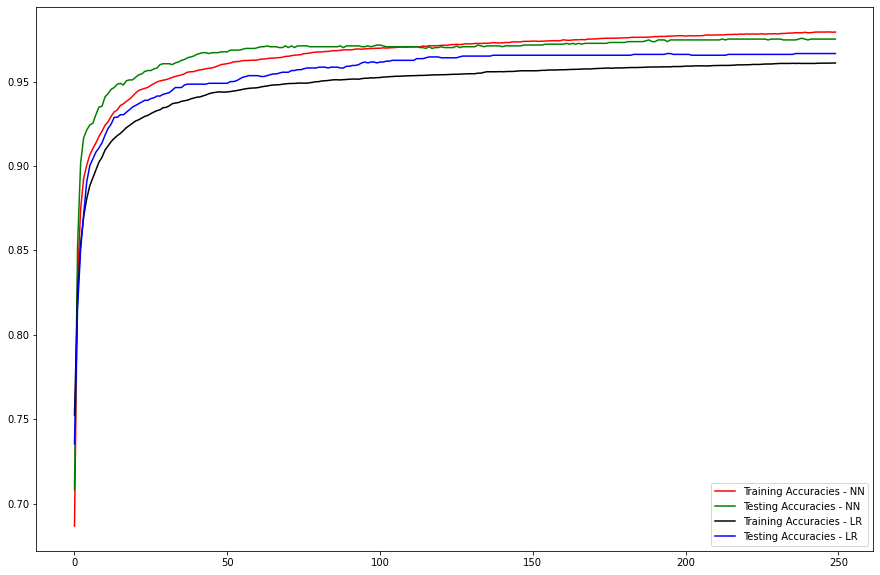

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

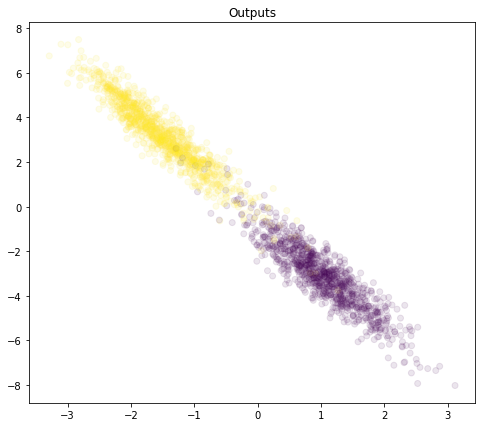

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

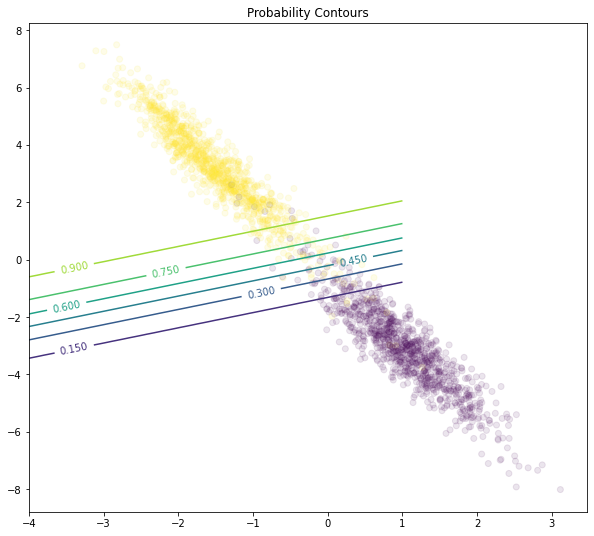

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );